# Лабораторная работа №1: Классификация текста

Выполнил: Артамонов Д.С, 20 МАГ ИАД

In [1]:
import gensim
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import re
import seaborn as sns
import sys
import wget
import zipfile

from tqdm import tqdm
from ufal.udpipe import Model, Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from utils.dataset import NewsDataset
import utils.embedding as emb

import webvectors.preprocessing.rus_preprocessing_udpipe as udpipe_preproc # cloned from https://github.com/akutuzov/webvectors/blob/master/preprocessing/rus_preprocessing_udpipe.py


Loading the model...
Processing input...


## Про данные

Заиспользуем датасет, собранный краулером из новостей с https://nplus1.ru. Будем учиться разбивать статьи на категории с помощью магии МЛ-а 🧙‍♂️

In [2]:
with open("nplus1_news.json") as f:
    corpus = json.load(f)

In [3]:
len(corpus)

6400

In [4]:
corpus[666]

{'id': 'https://nplus1.ru//news/2020/03/25/no-tanks',
 'text': 'Командование Морской пехоты США подготовило план реструктуризации этого вида вооруженных сил к 2030 году, предусматривающий сокращение численности состава, почти полного отказа от тяжелой техники и организации легких высокомобильных подразделений. Об этом изданию USNI News рассказал представитель Морской пехоты США майор Джошуа Бенсон. По его словам, полный план реструктуризации будет представлен комендантом Корпуса морской пехоты генералом Дэвидом Берджером в ближайшее время.\nРеорганизация Морской пехоты США будет проводиться для повышения боевых возможностей этого вида вооруженных сил и оптимизации его для ведения боевых действий с крупными государствами в прибрежных водах. В первую очередь американские военные рассматривают в качестве вероятного противника Китай. В числе запланированных мер — полная ликвидация танковых батальонов и упразднение соответствующих военно-учетных специальностей, расформирование подразделений

### Первичный анализ датасета

Чтобы было удобнее анализировать и предобрабатывать датасет, сделаем из json-а датафрейм:

In [5]:
news = pd.DataFrame(corpus)

In [6]:
news

,id,text,title,category,date
0,https://nplus1.ru//news/2020/01/01/haemophilia...,Врачи опубликовали результаты обследования пац...,Генную терапию против гемофилии А назвали безо...,"[Медицина, Биология]",2020-01-01
1,https://nplus1.ru//news/2020/01/03/ships,ВМС США в ближайшее время сформируют рабочую г...,ВМС США разработают концепцию применения больш...,[Оружие],2020-01-03
2,https://nplus1.ru//news/2020/01/03/manpads,Центральное разведывательное управление США ра...,Американцы разработали геозонирование для зени...,[Оружие],2020-01-03
3,https://nplus1.ru//news/2020/01/03/blagonravov,1 января 2020 года в возрасте 86 лет умер Алек...,Умер конструктор одной из самых массовых боевы...,[Оружие],2020-01-03
4,https://nplus1.ru//news/2020/01/03/loyalWingman,Министерство обороны Австралии планирует поста...,Австралийцы вооружатся беспилотными ведомыми в...,[Оружие],2020-01-03
...,...,...,...,...,...
6395,https://nplus1.ru//news/2021/10/08/epipaleolit...,Археологи обнаружили на эпипалеолитической сто...,Археологи нашли в Израиле древнейшие рыболовны...,[Археология],2021-10-08
6396,https://nplus1.ru//news/2021/10/08/pendraig-mi...,Палеонтологи описали новый род и вид теропод и...,Древнейшего хищного динозавра Великобритании н...,[Палеонтология],2021-10-08
6397,https://nplus1.ru//news/2021/10/09/irkut,Российские специалисты рассказали о технически...,Раскрыты характеристики российской многоразово...,[Космонавтика],2021-10-09
6398,https://nplus1.ru//news/2021/10/09/wing,Компания Wing построила на крыше торгового цен...,Wing построила дронопорт на крыше торгового це...,"[Роботы и дроны, Транспорт]",2021-10-09


Посмотрим на категории

In [7]:
categories = set()
for c in news['category']:
    categories.update({*c})

In [8]:
print(categories)

{'Транспорт', 'Психология', 'Блоги', 'Блокчейн', 'И о погоде', 'Гаджеты', 'Хлеб и вино', 'Органическое на 100% ', 'Экономика', 'Биология', 'Спортивная наука', 'Нейронауки', 'Когнитивные искажения', 'Физика', 'Космос', 'Время удивительных историй', 'Ф значит физика', 'Связь', 'Инфопартнерство', 'Обеспилочено', 'Реклама', 'Тихий час', 'Нобелевская премия', 'Квантовая азбука', 'Медицина', 'Бестиарий', 'Химия', 'Научные закрытия', 'Палеонтология', 'Технологии', 'Возвращение на Луну', 'Занимательная мемология', 'Разное', 'Путешествие «Юноны»', 'Ботаника', 'МАКС', 'Роботы и дроны', 'Геология', 'История', 'На мышах', 'Гендерные исследования', 'Языкознание', 'Итоги года', 'Памяти ученого', 'Зоология', 'Энергетика', 'New Horizons', 'Коронавирусные хроники', 'Физики смогли', 'Материалы', '3D-печать', 'Лингвистика', 'Solar Impulse 2', 'Премия «Просветитель»', 'Астрономия', 'Второй сезон Коллайдера', 'Раскопки', 'Социология', 'Оружие', 'Приключения «Хаябусы-2»', 'Сделай сам', 'Математика', 'Матема

Как оказалось, в датасете есть новости без категорий - найдём их и выпилим 🗡

In [9]:
news['category'].apply(lambda x: len(x) == 0).sum()

11

In [10]:
news_withot_category_filter = news['category'].apply(lambda x: len(x) == 0)
news['category'][news_withot_category_filter]

1065    []
1112    []
1955    []
2454    []
2469    []
2602    []
2612    []
2625    []
2994    []
3170    []
5821    []
Name: category, dtype: object

In [11]:
news[news_withot_category_filter]

,id,text,title,category,date
1065,https://nplus1.ru//news/2020/04/29/black-hole-...,Астрономам удалось с точностью до четырех часо...,Астрономы смогли предсказать вспышку в далекой...,[],2020-04-29
1112,https://nplus1.ru//news/2020/05/05/life-in-hyd...,"Микроорганизмы могут выжить в атмосфере, полно...",Кишечные палочки и дрожжи смогли выжить в водо...,[],2020-05-05
1955,https://nplus1.ru//news/2020/07/17/black-hole-...,"Астрономы впервые увидели, как корона из горяч...",Астрономы впервые увидели исчезновение короны ...,[],2020-07-17
2454,https://nplus1.ru//news/2020/09/04/ice-in-the-...,Площадь зимних льдов в Беринговом море сократи...,Берингово море потеряло рекордное количество з...,[],2020-09-04
2469,https://nplus1.ru//news/2020/09/07/insight-mar...,Ударный зонд инструмента HP3 автоматической ст...,Ударный зонд станции InSight начал самостоятел...,[],2020-09-07
2602,https://nplus1.ru//news/2020/09/18/aged-pet-dogs,"Снижение коммуникабельности, смелости, памяти,...",Диета и дрессировка не смогли замедлить старен...,[],2020-09-18
2612,https://nplus1.ru//news/2020/09/21/why-we-sleep,У детей в возрасте двух-трех лет происходит ре...,Функция сна изменилась у детей после двух лет,[],2020-09-21
2625,https://nplus1.ru//news/2020/09/22/spider-phobia,Женщины и мужчины с арахнофобией после столкно...,Мужчины и женщины по-разному справились со стр...,[],2020-09-22
2994,https://nplus1.ru//news/2020/10/28/clean-organics,Геологи нашли незагрязненную органику в метеор...,В детройтском метеорите нашли чистую органику,[],2020-10-28
3170,https://nplus1.ru//news/2020/11/17/plastic-pol...,"Экологи определили, как микропластик и твердые...",Прозрачная «почва» показала места скопления ми...,[],2020-11-17


Убираем новости без категорий:

In [12]:
news = news[~news_withot_category_filter]
news = news.reset_index(drop=True)

In [13]:
len(news)

6389

А ещё нужно удалить новости без текста. Некоторые странички отдают 404 код 

In [14]:
news_withot_test_filter = news['text'].apply(lambda x: len(x) == 0)

In [15]:
news[news_withot_test_filter]

,id,text,title,category,date
794,https://nplus1.ru//news/2020/04/07/giant-virus...,,Эволюция генов метаболизма у гигантских вирусо...,[Биология],2020-04-07
1266,https://nplus1.ru//news/2020/05/19/photocurent...,,Фотогальванический эффект помог измерить орбит...,[Физика],2020-05-19
1302,https://nplus1.ru//news/2020/05/21/pauli-crystals,,Впервые обнаружены кристаллы Паули,[Физика],2020-05-21
1489,https://nplus1.ru//news/2020/06/05/third-arm,,Носимую гидравлическую роборуку научили бить и...,"[Роботы и дроны, Мезонин]",2020-06-05
2791,https://nplus1.ru//news/2020/10/07/cheaper-hyd...,,Метод Монте-Карло подсказал пути оптимизации п...,[Энергетика],2020-10-07
3798,https://nplus1.ru//news/2021/02/01/Pt-WGS,,Платина и карбид молибдена помогли получить во...,"[Химия, Материалы]",2021-02-01
4424,https://nplus1.ru//news/2021/04/13/oldest-homo...,,Расшифрован старейший геном современного человека,"[Антропология, Биология, Генетика]",2021-04-13


In [16]:
news = news[~news_withot_test_filter]

Теперь немного упростим себе задачу и для каждой статьи оставим только одну категорию

In [17]:
news['category'] = news['category'].map(lambda c: c[0])

In [18]:
news.tail(5)

,id,text,title,category,date
6384,https://nplus1.ru//news/2021/10/08/epipaleolit...,Археологи обнаружили на эпипалеолитической сто...,Археологи нашли в Израиле древнейшие рыболовны...,Археология,2021-10-08
6385,https://nplus1.ru//news/2021/10/08/pendraig-mi...,Палеонтологи описали новый род и вид теропод и...,Древнейшего хищного динозавра Великобритании н...,Палеонтология,2021-10-08
6386,https://nplus1.ru//news/2021/10/09/irkut,Российские специалисты рассказали о технически...,Раскрыты характеристики российской многоразово...,Космонавтика,2021-10-09
6387,https://nplus1.ru//news/2021/10/09/wing,Компания Wing построила на крыше торгового цен...,Wing построила дронопорт на крыше торгового це...,Роботы и дроны,2021-10-09
6388,https://nplus1.ru//news/2021/10/09/ja-krevedko,Итальянские математики исследовали более двух ...,Усложнение мемов с годами доказали математически,Математика,2021-10-09


Посмотрим на распределние категорий

In [19]:
news.category.value_counts()

Оружие                    727
Зоология                  691
Медицина                  609
Астрономия                540
Космонавтика              463
Биология                  450
Физика                    437
Археология                376
Авиация                   297
Роботы и дроны            284
Экология и климат         225
Психология                217
Материалы                 139
IT                        135
Палеонтология             131
Транспорт                 114
Гаджеты                   111
Химия                     103
Антропология               86
Геология                   53
Мезонин                    28
3D-печать                  26
Ботаника                   24
История                    23
Связь                      20
Математика                 14
Социология                 14
Энергетика                 12
Лингвистика                11
Инфопартнерство             8
Космос                      4
Экономика                   2
Нобелевская премия          2
Блоги     

Ожидаемый дисбаланс. Интересно, что больше всего новостей про оружие

Выберем категории, в каторых количество новостей больше 400

In [20]:
categories_count = news.category.value_counts()
filtered_categories = set(categories_count[categories_count > 400].index)

In [21]:
filtered_categories

{'Астрономия',
 'Биология',
 'Зоология',
 'Космонавтика',
 'Медицина',
 'Оружие',
 'Физика'}

In [22]:
CATEGORIES_NUM = len(filtered_categories)

In [23]:
news = news[news.category.isin(filtered_categories)]

In [24]:
news.reset_index(drop=True, inplace=True)

In [25]:
news

,id,text,title,category,date
0,https://nplus1.ru//news/2020/01/01/haemophilia...,Врачи опубликовали результаты обследования пац...,Генную терапию против гемофилии А назвали безо...,Медицина,2020-01-01
1,https://nplus1.ru//news/2020/01/03/ships,ВМС США в ближайшее время сформируют рабочую г...,ВМС США разработают концепцию применения больш...,Оружие,2020-01-03
2,https://nplus1.ru//news/2020/01/03/manpads,Центральное разведывательное управление США ра...,Американцы разработали геозонирование для зени...,Оружие,2020-01-03
3,https://nplus1.ru//news/2020/01/03/blagonravov,1 января 2020 года в возрасте 86 лет умер Алек...,Умер конструктор одной из самых массовых боевы...,Оружие,2020-01-03
4,https://nplus1.ru//news/2020/01/03/loyalWingman,Министерство обороны Австралии планирует поста...,Австралийцы вооружатся беспилотными ведомыми в...,Оружие,2020-01-03
...,...,...,...,...,...
3912,https://nplus1.ru//news/2021/10/08/narew,\nПольский консорциум Polska Grupa Zbrojeniowa...,Поляки создадут ЗРК ближнего действия,Оружие,2021-10-08
3913,https://nplus1.ru//news/2021/10/08/dune-dune,Британские физики теоретически и экспериментал...,Песчаные дюны оказались способны образовывать ...,Физика,2021-10-08
3914,https://nplus1.ru//news/2021/10/08/burst-stimu...,\nКороткие импульсы тока по 200 миллисекунд сп...,Короткие импульсы продлили эффект глубокой сти...,Биология,2021-10-08
3915,https://nplus1.ru//news/2021/10/08/vertigo-genes,"Генетики из трех стран обнаружили шесть генов,...",Медики связали шесть генов с развитием головок...,Медицина,2021-10-08


### Лемматизация и стемминг с помощью чар Rusvectores

Используем [модельку](https://rusvectores.org/ru/models/), которая умеет делать лемматизацию и стемминг для текстов на русском. На выходе мы получим текст вида `врач_NOUN, опубликовывать_VERB, результат_NOUN` , который сразу можно отдать предобученному [Word2Vec](https://rusvectores.org/ru/models/)-у. На страничке с модельками в правилах предобработки можно найти ссылку на готовый хскрипт с пайплайномъ(https://github.com/akutuzov/webvectors/blob/master/preprocessing/rus_preprocessing_udpipe.py). Ради него и нужно было клонировать [webvectores](https://github.com/akutuzov/webvectors)

In [26]:
# udpipe_url = 'https://rusvectores.org/static/models/udpipe_syntagrus.model'

# modelfile = wget.download(udpipe_url)
# model = Model.load(modelfile)

# process_pipeline = Pipeline(model, 'tokenize',Pipeline.DEFAULT, Pipeline.DEFAULT, 'conllu')
# preprocessed_texts = [udpipe_preproc.process(process_pipeline, text=udpipe_preproc.unify_sym(text), keep_pos=True) for text in news.text]

# with open ("preprocessed.pickle", "wb") as f:
#     pickle.dump(preprocessed_texts, f)

Пайплайн отрабатывает очень медленно, поэтому результат сериализован и лежит в pickle фалйике

In [27]:
with open ("preprocessed.pickle", "rb") as f:
    preprocessed_texts = pickle.load(f)

In [28]:
len(preprocessed_texts)

3917

Добавляем колонку с токенами в наш датафрейм

In [29]:
news.insert(5, 'tokens', preprocessed_texts)

In [30]:
news

,id,text,title,category,date,tokens
0,https://nplus1.ru//news/2020/01/01/haemophilia...,Врачи опубликовали результаты обследования пац...,Генную терапию против гемофилии А назвали безо...,Медицина,2020-01-01,"[врач_NOUN, опубликовывать_VERB, результат_NOU..."
1,https://nplus1.ru//news/2020/01/03/ships,ВМС США в ближайшее время сформируют рабочую г...,ВМС США разработают концепцию применения больш...,Оружие,2020-01-03,"[вмс::сша_PROPN, в_ADP, ближайший_ADJ, время_N..."
2,https://nplus1.ru//news/2020/01/03/manpads,Центральное разведывательное управление США ра...,Американцы разработали геозонирование для зени...,Оружие,2020-01-03,"[центральный_ADJ, разведывательный_ADJ, управл..."
3,https://nplus1.ru//news/2020/01/03/blagonravov,1 января 2020 года в возрасте 86 лет умер Алек...,Умер конструктор одной из самых массовых боевы...,Оружие,2020-01-03,"[x_NUM, январь_NOUN, xxxx_NUM, год_NOUN, в_ADP..."
4,https://nplus1.ru//news/2020/01/03/loyalWingman,Министерство обороны Австралии планирует поста...,Австралийцы вооружатся беспилотными ведомыми в...,Оружие,2020-01-03,"[министерство_PROPN, оборона_NOUN, австралия_P..."
...,...,...,...,...,...,...
3912,https://nplus1.ru//news/2021/10/08/narew,\nПольский консорциум Polska Grupa Zbrojeniowa...,Поляки создадут ЗРК ближнего действия,Оружие,2021-10-08,"[польский_ADJ, консорциум_NOUN, polska_PROPN, ..."
3913,https://nplus1.ru//news/2021/10/08/dune-dune,Британские физики теоретически и экспериментал...,Песчаные дюны оказались способны образовывать ...,Физика,2021-10-08,"[британский_ADJ, физика_NOUN, теоретически_ADV..."
3914,https://nplus1.ru//news/2021/10/08/burst-stimu...,\nКороткие импульсы тока по 200 миллисекунд сп...,Короткие импульсы продлили эффект глубокой сти...,Биология,2021-10-08,"[короткий_ADJ, импульс_NOUN, ток_NOUN, по_ADP,..."
3915,https://nplus1.ru//news/2021/10/08/vertigo-genes,"Генетики из трех стран обнаружили шесть генов,...",Медики связали шесть генов с развитием головок...,Медицина,2021-10-08,"[генетика_NOUN, из_ADP, три_NUM, страна_NOUN, ..."


In [31]:
print(news.iloc[42]['tokens'])

['американский_ADJ', 'ученый_NOUN', 'обнаруживать_VERB', 'в_ADP', 'кровь_NOUN', 'человек_NOUN', 'сотня_NOUN', 'вещество_NOUN', 'концентрация_NOUN', 'который_PRON', 'мочь_VERB', 'закономерно_ADV', 'меняться_VERB', 'с_ADP', 'возраст_NOUN', 'они_PRON', 'выяснять_VERB', 'что_SCONJ', 'выделять_VERB', 'среди_ADP', 'они_PRON', 'однозначный_ADJ', 'маркер_NOUN', 'биологический_ADJ', 'возраст_NOUN', 'сложный_ADJ', 'всегда_ADV', 'находиться_VERB', 'человек_NOUN', 'который_PRON', 'не_PART', 'укладываться_VERB', 'в_ADP', 'общий_ADJ', 'правило_NOUN', 'зато_CCONJ', 'оказываться_VERB', 'что_SCONJ', 'весь_DET', 'этот_DET', 'маркер_NOUN', 'можно_ADV', 'разделять_VERB', 'на_ADP', 'четыре_NUM', 'группа_NOUN', 'связывать_VERB', 'с_ADP', 'иммунитет_NOUN', 'обмен_NOUN', 'вещество_NOUN', 'дисфункциий_NOUN', 'почка_NOUN', 'или_CCONJ', 'печень_NOUN', 'в_ADP', 'результат_NOUN', 'весь_DET', 'участник_NOUN', 'исследование_NOUN', 'удаваться_VERB', 'разделять_VERB', 'по_ADP', 'тип_NOUN', 'старение_NOUN', 'у_ADP', 'к

Продолжим препроцессинг. Уберём все стоп-слова: предлоги(_ADP), местоимения(_PRON, _DET), чачтицы(_PART), союзы(_CCONJ, _SCONJ), числа (_NUM)

In [32]:
stop_words = ['ADP', 'PRON', 'DET', 'PART', 'CCONJ',  'SCONJ', 'NUM' ]

In [33]:
news.tokens = news.tokens.apply(lambda tkn: [ t for t in tkn if re.split('_', t)[1] not in stop_words ])

In [34]:
news

,id,text,title,category,date,tokens
0,https://nplus1.ru//news/2020/01/01/haemophilia...,Врачи опубликовали результаты обследования пац...,Генную терапию против гемофилии А назвали безо...,Медицина,2020-01-01,"[врач_NOUN, опубликовывать_VERB, результат_NOU..."
1,https://nplus1.ru//news/2020/01/03/ships,ВМС США в ближайшее время сформируют рабочую г...,ВМС США разработают концепцию применения больш...,Оружие,2020-01-03,"[вмс::сша_PROPN, ближайший_ADJ, время_NOUN, фо..."
2,https://nplus1.ru//news/2020/01/03/manpads,Центральное разведывательное управление США ра...,Американцы разработали геозонирование для зени...,Оружие,2020-01-03,"[центральный_ADJ, разведывательный_ADJ, управл..."
3,https://nplus1.ru//news/2020/01/03/blagonravov,1 января 2020 года в возрасте 86 лет умер Алек...,Умер конструктор одной из самых массовых боевы...,Оружие,2020-01-03,"[январь_NOUN, год_NOUN, возраст_NOUN, год_NOUN..."
4,https://nplus1.ru//news/2020/01/03/loyalWingman,Министерство обороны Австралии планирует поста...,Австралийцы вооружатся беспилотными ведомыми в...,Оружие,2020-01-03,"[министерство_PROPN, оборона_NOUN, австралия_P..."
...,...,...,...,...,...,...
3912,https://nplus1.ru//news/2021/10/08/narew,\nПольский консорциум Polska Grupa Zbrojeniowa...,Поляки создадут ЗРК ближнего действия,Оружие,2021-10-08,"[польский_ADJ, консорциум_NOUN, polska_PROPN, ..."
3913,https://nplus1.ru//news/2021/10/08/dune-dune,Британские физики теоретически и экспериментал...,Песчаные дюны оказались способны образовывать ...,Физика,2021-10-08,"[британский_ADJ, физика_NOUN, теоретически_ADV..."
3914,https://nplus1.ru//news/2021/10/08/burst-stimu...,\nКороткие импульсы тока по 200 миллисекунд сп...,Короткие импульсы продлили эффект глубокой сти...,Биология,2021-10-08,"[короткий_ADJ, импульс_NOUN, ток_NOUN, миллисе..."
3915,https://nplus1.ru//news/2021/10/08/vertigo-genes,"Генетики из трех стран обнаружили шесть генов,...",Медики связали шесть генов с развитием головок...,Медицина,2021-10-08,"[генетика_NOUN, страна_NOUN, обнаруживать_VERB..."


Какодируем категории циферками:

In [35]:
labels, label_to_category = news.category.factorize()

In [36]:
label_to_category

Index(['Медицина', 'Оружие', 'Физика', 'Биология', 'Астрономия', 'Зоология',
       'Космонавтика'],
      dtype='object')

In [37]:
news = news.assign(labels=labels)

In [38]:
news

,id,text,title,category,date,tokens,labels
0,https://nplus1.ru//news/2020/01/01/haemophilia...,Врачи опубликовали результаты обследования пац...,Генную терапию против гемофилии А назвали безо...,Медицина,2020-01-01,"[врач_NOUN, опубликовывать_VERB, результат_NOU...",0
1,https://nplus1.ru//news/2020/01/03/ships,ВМС США в ближайшее время сформируют рабочую г...,ВМС США разработают концепцию применения больш...,Оружие,2020-01-03,"[вмс::сша_PROPN, ближайший_ADJ, время_NOUN, фо...",1
2,https://nplus1.ru//news/2020/01/03/manpads,Центральное разведывательное управление США ра...,Американцы разработали геозонирование для зени...,Оружие,2020-01-03,"[центральный_ADJ, разведывательный_ADJ, управл...",1
3,https://nplus1.ru//news/2020/01/03/blagonravov,1 января 2020 года в возрасте 86 лет умер Алек...,Умер конструктор одной из самых массовых боевы...,Оружие,2020-01-03,"[январь_NOUN, год_NOUN, возраст_NOUN, год_NOUN...",1
4,https://nplus1.ru//news/2020/01/03/loyalWingman,Министерство обороны Австралии планирует поста...,Австралийцы вооружатся беспилотными ведомыми в...,Оружие,2020-01-03,"[министерство_PROPN, оборона_NOUN, австралия_P...",1
...,...,...,...,...,...,...,...
3912,https://nplus1.ru//news/2021/10/08/narew,\nПольский консорциум Polska Grupa Zbrojeniowa...,Поляки создадут ЗРК ближнего действия,Оружие,2021-10-08,"[польский_ADJ, консорциум_NOUN, polska_PROPN, ...",1
3913,https://nplus1.ru//news/2021/10/08/dune-dune,Британские физики теоретически и экспериментал...,Песчаные дюны оказались способны образовывать ...,Физика,2021-10-08,"[британский_ADJ, физика_NOUN, теоретически_ADV...",2
3914,https://nplus1.ru//news/2021/10/08/burst-stimu...,\nКороткие импульсы тока по 200 миллисекунд сп...,Короткие импульсы продлили эффект глубокой сти...,Биология,2021-10-08,"[короткий_ADJ, импульс_NOUN, ток_NOUN, миллисе...",3
3915,https://nplus1.ru//news/2021/10/08/vertigo-genes,"Генетики из трех стран обнаружили шесть генов,...",Медики связали шесть генов с развитием головок...,Медицина,2021-10-08,"[генетика_NOUN, страна_NOUN, обнаруживать_VERB...",0


Добавим немножечко Word2Vec-a. Скачаем модель, а преобразовывать будем уже внутри pytorch Dataset

In [39]:
model_file = 'w2v.zip'
with zipfile.ZipFile(model_file, 'r') as archive:
    stream = archive.open('model.bin')
    model = gensim.models.KeyedVectors.load_word2vec_format(stream, binary=True)

Нестареющая классика

In [40]:
print(model.most_similar(positive=['пицца_NOUN', 'франция_NOUN'], negative=['италия_NOUN'])[0][0])

круассан_NOUN


С помощью w2v модельки сделаем эмбединги для каждого документа как среднее токенов документа

In [41]:
EMBEDDING_SIZE = 300

In [42]:
w2v_model = emb.W2V(model=model, embeding_size=EMBEDDING_SIZE)

In [43]:
X = np.zeros([len(news["tokens"]), EMBEDDING_SIZE])
for i,doc in enumerate(news["tokens"]):
    X[i] = w2v_model.make_doc_embedding(doc)

In [44]:
y = np.array(news["labels"])

Разбиваем выборку на train/test:

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

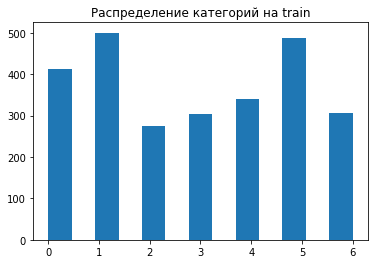

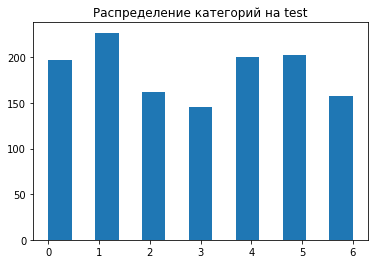

In [46]:
_ = plt.hist(y_train, bins=13)
plt.title("Распределение категорий на train")
plt.show()

_ = plt.hist(y_test, bins=13)
plt.title("Распределение категорий на test")
plt.show()

### KNeighborsClassifier

In [47]:
from sklearn.neighbors import KNeighborsClassifier as KNN

In [156]:
def knn_score(n_neighbors):
    knn = KNN(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    return y_pred

Начнём с [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier) 

In [48]:
knn = KNN(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [49]:
y_pred = knn.predict(X_test)

In [50]:
accuracy = (y_test == y_pred).sum() / len(y_test)
print(f"Accuracy score is {accuracy:.3f}")

Accuracy score is 0.879


In [52]:
conf_mat = confusion_matrix(y_test, y_pred)

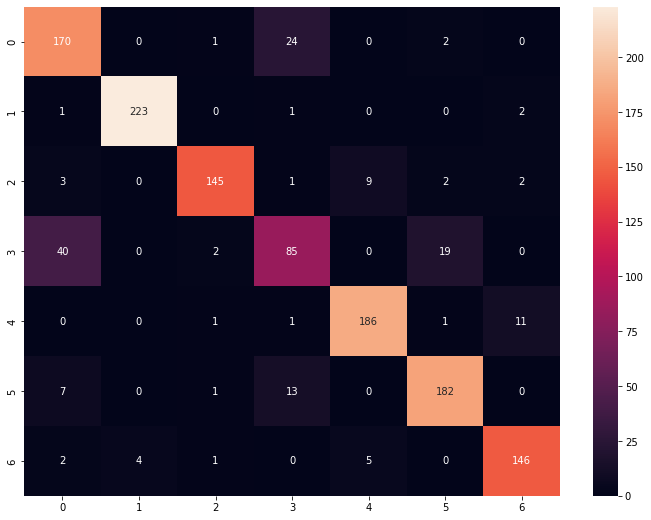

In [53]:
plt.figure(figsize = (12,9))
sns.heatmap(conf_mat, annot=True, fmt=".3g")
plt.show()

Больше всего ошибок в категориях:

In [154]:
print(f"{label_to_category[3]} и {label_to_category[0]}, {label_to_category[3]} и {label_to_category[5]}, {label_to_category[4]} и {label_to_category[6]} ") 

Биология и Медицина, Биология и Зоология, Астрономия и Космонавтика 


Попробуем посмотреть, как влияет количество соседей:

In [159]:
for n in (3,5,7,10,15,30, 50, 100, 200, 300, 500):
    y_pred = knn_score(n)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"For {n} neighbors: Accuracy score is {accuracy:.3f}")

For 3 neighbors: Accuracy score is 0.879
For 5 neighbors: Accuracy score is 0.881
For 7 neighbors: Accuracy score is 0.884
For 10 neighbors: Accuracy score is 0.877
For 15 neighbors: Accuracy score is 0.878
For 30 neighbors: Accuracy score is 0.881
For 50 neighbors: Accuracy score is 0.876
For 100 neighbors: Accuracy score is 0.877
For 200 neighbors: Accuracy score is 0.861
For 300 neighbors: Accuracy score is 0.865
For 500 neighbors: Accuracy score is 0.814


Если соседей больше 100 - точность начинает быстро падать

## LogisticRegression

Теперь попробуем [логистическую регрессию](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [54]:
from sklearn.linear_model import LogisticRegression

In [55]:
lr = LogisticRegression(max_iter=1000)

In [56]:
lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [57]:
y_pred_lr = lr.predict(X_test)

In [161]:
accuracy = accuracy_score(y_test, y_pred_lr)
print(f"Accuracy score is {accuracy:.3f}")

Accuracy score is 0.885


In [59]:
conf_mat = confusion_matrix(y_test, y_pred_lr)

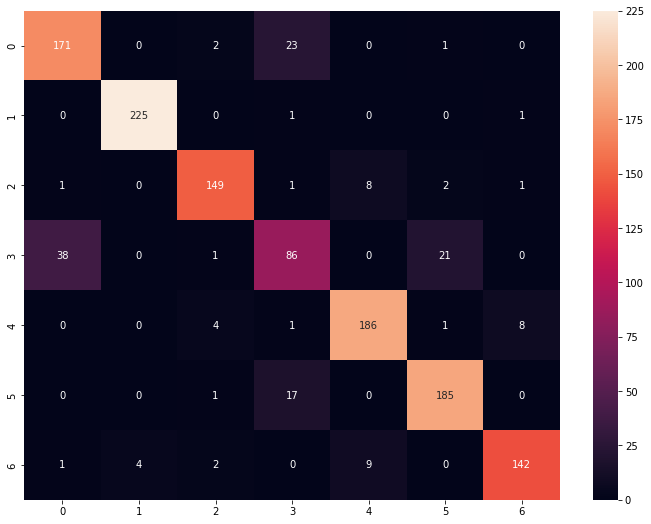

In [60]:
plt.figure(figsize = (12,9))
sns.heatmap(conf_mat, annot=True, fmt=".3g")
plt.show()

Больше всего ошибок в категориях:

In [155]:
print(f"{label_to_category[3]} и {label_to_category[0]}, {label_to_category[3]} и {label_to_category[5]}, {label_to_category[4]} и {label_to_category[6]} ") 

Биология и Медицина, Биология и Зоология, Астрономия и Космонавтика 


## Нейроночки

In [62]:
import torch
import torch.nn as nn

from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

In [63]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [120]:
writer = SummaryWriter()

In [86]:
news_dataset = NewsDataset(news, w2v_model)

Так как у нас уже есть веткорное представление для текстов, попробуем использовать простую нейронку с 2-мя линейными слоями

In [77]:
class NewsDenseNet(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(NewsDenseNet, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)


    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Разобьём весь наш датасет на тринировочный, валидационный и тестовый:

In [87]:
train_len = int(len(news_dataset) * 0.8)
val_len = int(train_len * 0.1)
test_len = len(news_dataset) - train_len - val_len

print(f"Train dataset size: {train_len}")
print(f"Validaition dataset size: {val_len}")
print(f"Test dataset size: {test_len}")
train_dataset, val_dataset, test_dataset = random_split(news_dataset, [train_len, val_len, test_len])

Train dataset size: 3133
Validaition dataset size: 313
Test dataset size: 471


Функция для тренировки модели за одну эпоху:

In [121]:
def train(train_dataset, model, optimizer, criterion):
    train_loss = 0
    train_acc = 0
    train_dataset_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    for i, (text, label) in enumerate(train_dataset_loader):
        
        optimizer.zero_grad()
        text, label = text.to(device), label.to(device)
        output = model(text.float())        
        loss = criterion(output, label)
        train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        train_acc += (output.argmax(1) == label).sum().item()
    return train_loss / len(train_dataset), train_acc / len(train_dataset)

Функция для валидации/теста

In [122]:
def test(model, test_dataset):
    accuracy = 0
    test_dataset_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

    for text, label in test_dataset_loader:
        text, label = text.to(device), label.to(device)
        with torch.no_grad():
            output = model(text.float())
            accuracy += (output.argmax(1) == label).sum().item()
    return accuracy / len(test_dataset)


In [124]:
input_size = EMBEDDING_SIZE
output_size = CATEGORIES_NUM
hidden_size = 64

N_EPOCHS = 10
BATCH_SIZE=32

In [125]:
model = NewsDenseNet(input_size, hidden_size, output_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = torch.nn.CrossEntropyLoss().to(device)

In [126]:
best_valid_acc = 0
best_model = None

for epoch in tqdm(range(N_EPOCHS)):
    # Train Step

    train_loss, train_acc = train(train_dataset, model, optimizer, criterion)
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("Accuracy/train", train_acc, epoch)
    
    
    # Validation step
    valid_accuracy = test(model, val_dataset)
    writer.add_scalar("Accuracy/validation", valid_accuracy, epoch)
    
    print(f"#{epoch}: Train loss {train_loss:.4f}, accuracy {accuracy:.4f}. Val accuracy {valid_accuracy:.4f}")
    
    # Comparing models and saving the best one
    if best_valid_acc < valid_accuracy:
        print("Update model")
        best_valid_acc = valid_accuracy
        best_model = model
        

writer.flush()        
writer.close()

 10%|████▍                                       | 1/10 [00:03<00:35,  3.91s/it]

#0: Train loss 0.0270, accuracy 0.8794. Val accuracy 0.8658
Update model


 20%|████████▊                                   | 2/10 [00:07<00:30,  3.81s/it]

#1: Train loss 0.0103, accuracy 0.8794. Val accuracy 0.8530


 30%|█████████████▏                              | 3/10 [00:11<00:26,  3.81s/it]

#2: Train loss 0.0092, accuracy 0.8794. Val accuracy 0.8658


 40%|█████████████████▌                          | 4/10 [00:15<00:22,  3.77s/it]

#3: Train loss 0.0087, accuracy 0.8794. Val accuracy 0.8626


 50%|██████████████████████                      | 5/10 [00:18<00:18,  3.75s/it]

#4: Train loss 0.0080, accuracy 0.8794. Val accuracy 0.8658


 60%|██████████████████████████▍                 | 6/10 [00:22<00:15,  3.76s/it]

#5: Train loss 0.0079, accuracy 0.8794. Val accuracy 0.8754
Update model


 70%|██████████████████████████████▊             | 7/10 [00:26<00:11,  3.76s/it]

#6: Train loss 0.0076, accuracy 0.8794. Val accuracy 0.8562


 80%|███████████████████████████████████▏        | 8/10 [00:30<00:07,  3.79s/it]

#7: Train loss 0.0073, accuracy 0.8794. Val accuracy 0.8818
Update model


 90%|███████████████████████████████████████▌    | 9/10 [00:34<00:03,  3.78s/it]

#8: Train loss 0.0067, accuracy 0.8794. Val accuracy 0.8818


100%|███████████████████████████████████████████| 10/10 [00:37<00:00,  3.79s/it]

#9: Train loss 0.0070, accuracy 0.8794. Val accuracy 0.8658


In [129]:
test_accuracy = test(best_model, test_dataset)
print(f"test accuracy:{test_accuracy:.4f}")

test accuracy:0.8896


In [ ]:
test_dataset_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
with torch.no_grad():
    output = best_model(text.float())
    accuracy += (output.argmax(1) == label).sum().item()

In [134]:
accuracy = 0
test_dataset_loader = DataLoader(test_dataset, batch_size=len(test_dataset))
text, label = next(iter(test_dataset_loader))
text, label = text.to(device), label.to(device)
with torch.no_grad():
    output = model(text.float())

In [142]:
conf_mat = confusion_matrix(label.cpu().numpy(), output.argmax(1).cpu().numpy())

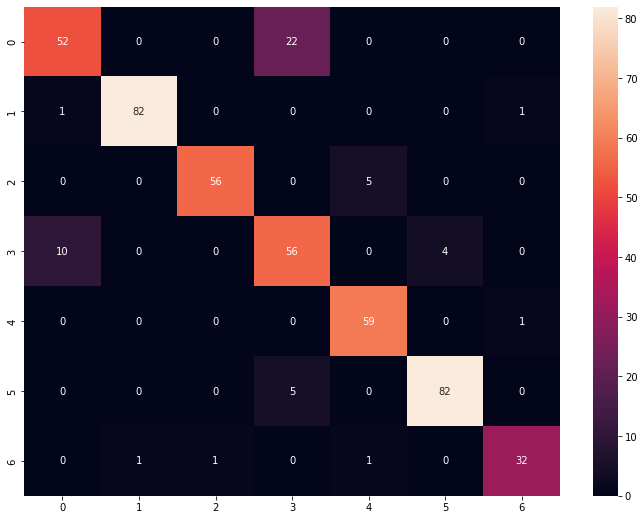

In [143]:
plt.figure(figsize = (12,9))
sns.heatmap(conf_mat, annot=True, fmt=".3g")
plt.show()

От классических методов почти не отличается

Больше всего ошибок в категориях:

In [152]:
print(f"{label_to_category[3]} и {label_to_category[0]}") 

Биология и Медицина


и

In [151]:
print(f"{label_to_category[3]} и {label_to_category[5]}") 

Биология и Зоология


Сохраним модельку:

In [162]:
torch.save(best_model.state_dict(), "NewsDenseNet.pt")

## Подытожим

Из датасета с новостями мы выбрали новости, входяшие в 7 наиболее популярных категорий. Применили лематизацию и стемминг и скормили все тексты в предобученный Word2Vec. Далее усреднили эмбединги слов для каждого текста и для каждой текста получили один вектор.

Потом мы построили несколько моделек для классификации: 
* KNN classifier
* Logistic Regression
* NN (2 linear layers)

Итоговая точность оказалось практически одинаковой для каждого из методов ( ~88%). То есть с полученными векторными представлениями мы смогли использовать простые модели для классификации и получить приемлимую точность

Сильнее всего путаются категории "Медицина" и "Биология" и "Зоология" и "Биология", что логично 🧐